Добрый день. Тестовое задание .

дано видео, необходимо ,взять каждый 15 кадр из него 

и согласно координатам вырезать картинку и сделать решейп на 116*116,

сохранить данный изображения в папке, 

далее в ручную рассортировать в две папки ,первая где есть человек на рабочем месте, вторая где пустой стол. 

вторая часть необязательная ,мы получили базу из двух папок ,обучить на ней нейронную сеть классификатор на keras и pytorch .

чем меньше будет модель тем лучше 

https://disk.yandex.ru/d/zrh9-rYmgRgxPQ 

результаты выслать на почту 
k73.kondrashov@gmail.com

Ближний стол (на картинке левый)

xmin,ymin = 115, 210

xmax, ymax = 350, 445

координаты на изображении

https://disk.yandex.ru/i/CpKFuMNKmswEWA

видео

https://disk.yandex.ru/i/9AuLkzsd55083w

Brief of task:
- Need to take from video every 15th frame
- Crop image by coordinates xmin,ymin = 115, 210, xmax,ymax = 350,445
- Reshape to 116x116
- Sort images by neural networks on keras and pytorch
 - "0" - person is absence
 - "1" - person is presence
- Save model and share with customer

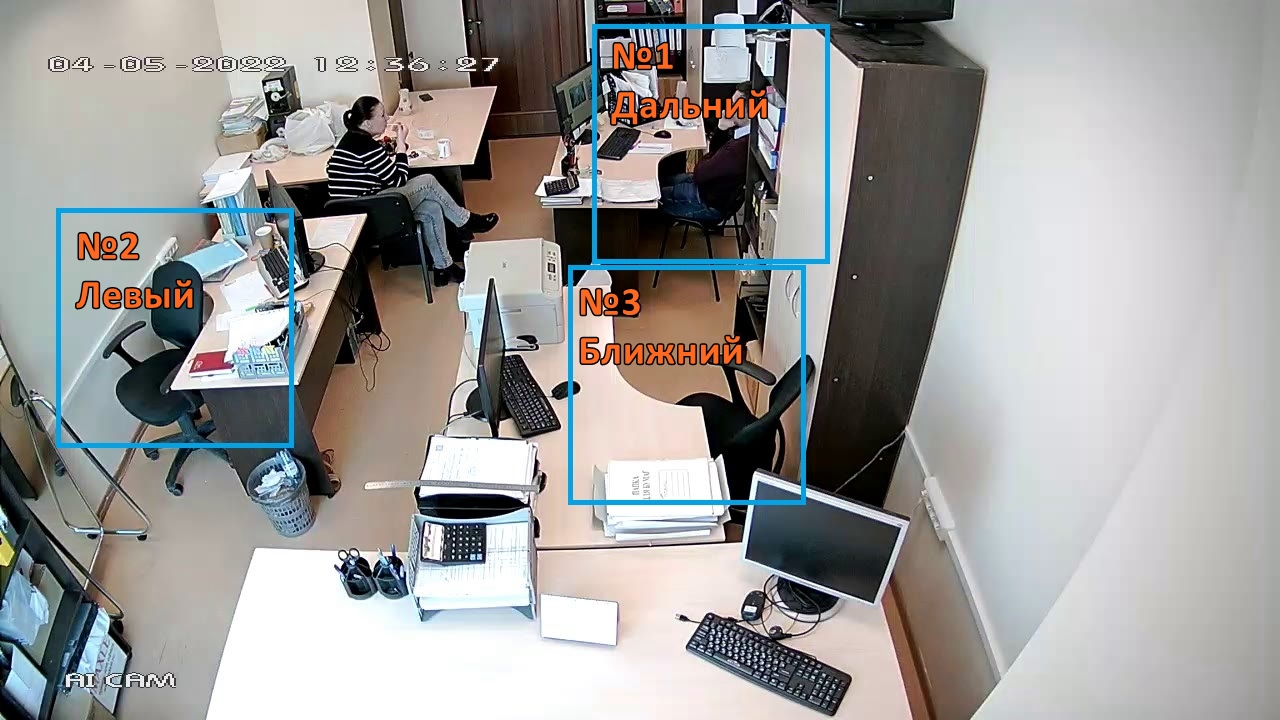

# Train data preparation

In [1]:
# Import all needed libraries
import cv2
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import random

random.seed(32)
np.random.seed(32)
torch.manual_seed(32)
torch.cuda.manual_seed(32)
print('Setup complete')

Setup complete


In [2]:
vid = cv2.VideoCapture('Camera 3_20220526_003249.mp4')

if not os.path.exists('images_for_train'):
    os.makedirs('images_for_train')
    
# frames rate
FRAMES=15*100

pbar = tqdm(total=int(vid.get(cv2.CAP_PROP_FRAME_COUNT) / FRAMES))
index = 0
while(True):
    ret, frame = vid.read()
    if not ret: 
        break
    name = 'images/Camera 3_' + str(index) + '.jpg'
    if index%FRAMES==0:
        cv2.imwrite(name, cv2.resize(frame[115:350, 210:445], (116,116)))
        pbar.update(1)
    index += 1
    
pbar.close()

  0%|          | 0/376 [00:00<?, ?it/s]

# Manual sorting images
I manually sorted images to train model in folder data

In [52]:
! ls data

0  1


# Data preparation

In [20]:
import shutil 

train_dir = 'train'
val_dir = 'val'

class_names = ['0', '1']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join('data', class_name) # replace 'data' to 'torch_sort' to train nn on all data
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

  0%|          | 0/401 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

# Torch

In [30]:
train_transforms1 = transforms.Compose([transforms.Resize(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transforms2 = transforms.Compose([transforms.Resize(224),
                                        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.3, hue=0.3),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transfroms = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset1 = torchvision.datasets.ImageFolder(train_dir, train_transforms1)
train_dataset2 = torchvision.datasets.ImageFolder(train_dir, train_transforms2)
train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2])

val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transfroms)

batch_size = 12
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [31]:
print(len(train_dataloader), len(train_dataset))
len(val_dataloader), len(val_dataset)

84 998


(11, 132)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


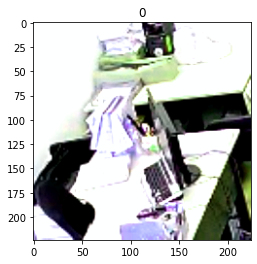

In [32]:
X_batch, y_batch = next(iter(train_dataloader))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(X_batch[0].shape)

plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)
plt.title(class_names[y_batch[0]]);

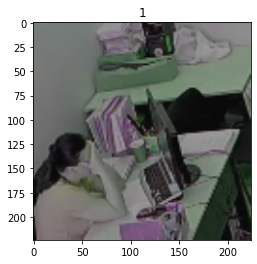

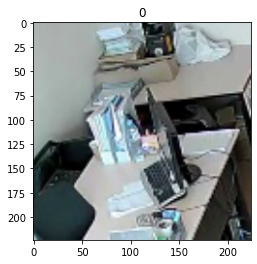

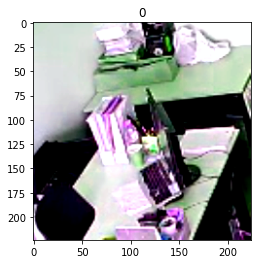

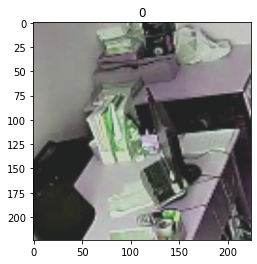

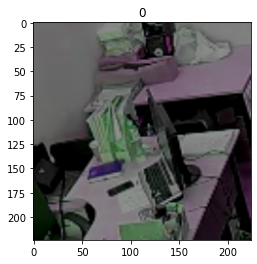

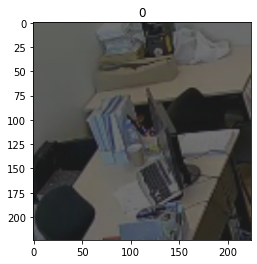

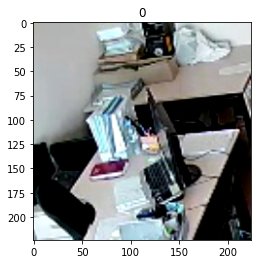

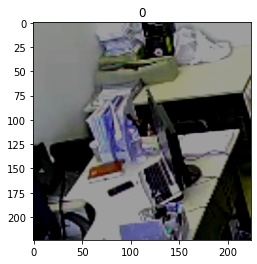

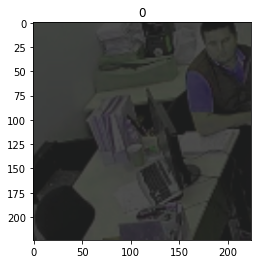

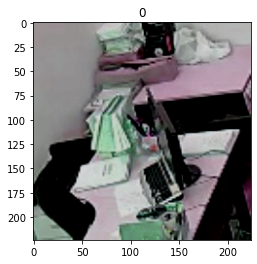

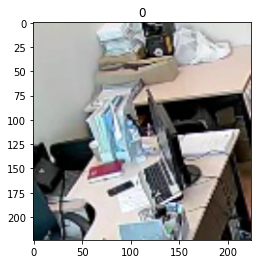

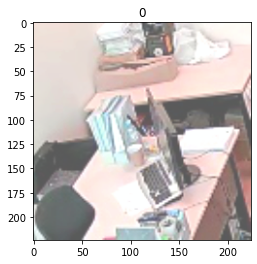

In [33]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [44]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode
                train_accuracy_history.append(epoch_acc.data.cpu())
                train_loss_history.append(epoch_loss)

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                      
                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc.data.cpu())

            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [45]:
# We're trying to use ResNet18 firstly
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

# For last fully connected layer we use two classes
model.fc = torch.nn.Linear(model.fc.in_features, 2)

# GPU activation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

# Loss function
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

cuda:0


## Train resnet18

In [47]:
train_accuracy_history = []
train_loss_history = []
val_accuracy_history = []
val_loss_history = []

train_model(model, loss, optimizer, scheduler, num_epochs=30);

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.4151 Acc: 0.8105


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.3194 Acc: 0.9167
Epoch 1/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3781 Acc: 0.8403


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2920 Acc: 0.9470
Epoch 2/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3540 Acc: 0.8710


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2601 Acc: 0.9545
Epoch 3/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3396 Acc: 0.8690


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2295 Acc: 0.9394
Epoch 4/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3125 Acc: 0.9008


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2364 Acc: 0.9545
Epoch 5/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3109 Acc: 0.9008


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2299 Acc: 0.9545
Epoch 6/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3013 Acc: 0.9087


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2256 Acc: 0.9545
Epoch 7/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3054 Acc: 0.8958


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2178 Acc: 0.9545
Epoch 8/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3143 Acc: 0.8958


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2235 Acc: 0.9545
Epoch 9/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3024 Acc: 0.8968


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2192 Acc: 0.9545
Epoch 10/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3040 Acc: 0.8988


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2209 Acc: 0.9545
Epoch 11/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3110 Acc: 0.8958


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2149 Acc: 0.9545
Epoch 12/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3008 Acc: 0.9018


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2247 Acc: 0.9545
Epoch 13/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3078 Acc: 0.8958


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2207 Acc: 0.9545
Epoch 14/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.2985 Acc: 0.8998


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2258 Acc: 0.9545
Epoch 15/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3133 Acc: 0.8998


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2213 Acc: 0.9621
Epoch 16/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3105 Acc: 0.8929


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2238 Acc: 0.9545
Epoch 17/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.2938 Acc: 0.9058


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2265 Acc: 0.9545
Epoch 18/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3174 Acc: 0.8889


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2174 Acc: 0.9545
Epoch 19/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3007 Acc: 0.8998


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2202 Acc: 0.9545
Epoch 20/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3065 Acc: 0.8948


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2132 Acc: 0.9545
Epoch 21/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3068 Acc: 0.8988


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2162 Acc: 0.9470
Epoch 22/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3104 Acc: 0.8839


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2166 Acc: 0.9545
Epoch 23/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3068 Acc: 0.8988


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2199 Acc: 0.9545
Epoch 24/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.2886 Acc: 0.9097


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2154 Acc: 0.9545
Epoch 25/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3134 Acc: 0.8810


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2115 Acc: 0.9545
Epoch 26/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.2997 Acc: 0.9048


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2199 Acc: 0.9545
Epoch 27/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3060 Acc: 0.8978


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2199 Acc: 0.9545
Epoch 28/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3071 Acc: 0.9058


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2165 Acc: 0.9545
Epoch 29/29:


  0%|          | 0/84 [00:00<?, ?it/s]

train Loss: 0.3035 Acc: 0.8998


  0%|          | 0/11 [00:00<?, ?it/s]

val Loss: 0.2242 Acc: 0.9697


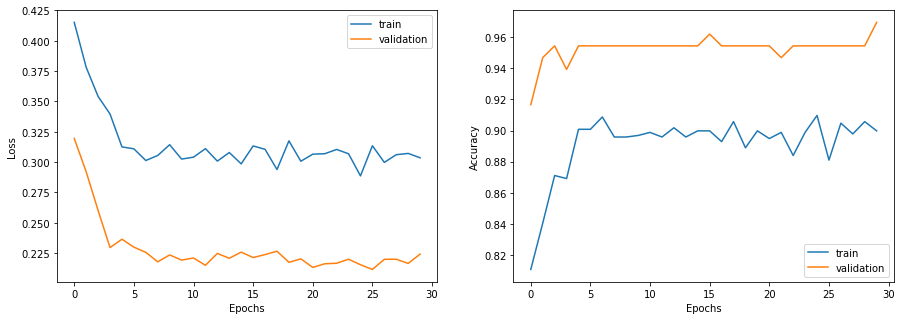

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='train')
plt.plot(val_accuracy_history, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

## Saving model

In [49]:
torch.save(model, 'torch_model')

## Prepare folder with all needed images

In [15]:
# Let's save every 15th frame
if not os.path.exists('images'):
    os.makedirs('images')
    
# frames rate
FRAMES=15

pbar = tqdm(total=int(vid.get(cv2.CAP_PROP_FRAME_COUNT) / FRAMES))
index = 0
while(True):
    ret, frame = vid.read()
    if not ret: 
        break
    name = 'images/Camera 3_' + str(index) + '.jpg'
    if index%FRAMES==0:
        cv2.imwrite(name, cv2.resize(frame[115:350, 210:445], (116,116)))
        pbar.update(1)
    index += 1
    
pbar.close()

  0%|          | 0/37683 [00:00<?, ?it/s]

## Sorting images by nn on pytorch 

In [50]:
import torch
from torch.autograd import Variable
from torchvision import transforms
import os
import shutil
from PIL import Image
from tqdm.notebook import tqdm


def get_img(image_path):
    img_list = []
    for i in os.listdir(image_path):
        img_list.append(image_path+"/"+i)
    return img_list

def load_models():
    model = torch.load('torch_model')
    model.eval()
    return model


def predict_image(image_path):
    image = Image.open(image_path)

    transformation = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    image_tensor = transformation(image)#.float() # Предварительно обработать изображение
    image_tensor = image_tensor.unsqueeze_(0)    # Добавить дополнительное измерение партии, потому что PyTorch обрабатывает все изображения как партии

    if torch.cuda.is_available():
        image_tensor.cuda()

    model = load_models()

    input = Variable(image_tensor.cuda())   # Превратить ввод в переменную
    output = model(input)                   # Прогнозировать класс изображения
    index = output.data.cpu().numpy().argmax()
    return index

if __name__ == '__main__':
    image_path = r'images/'
    img_list = get_img(image_path)
    for i in tqdm(img_list):
        index = predict_image(i)
        id2tag = {0:'0',1: '1'}
        #print(index)
        #print(id2tag[index])
        target = 'torch_sort/'+id2tag[index]
        if os.path.exists(target):
            shutil.copy(i, target)
        else:
            os.mkdir(target)
        shutil.copy(i, target)

  0%|          | 0/37453 [00:00<?, ?it/s]

# TensorFlow | Keras

Switched to other enviroment to proceed with tf-gpu

In [2]:
# keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.utils import image_dataset_from_directory

2022-09-20 21:37:51.886798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 21:37:52.262589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 21:37:53.156413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mikhail/anaconda3/lib/:/home/mikhail/anaconda3/lib/:/home/mikhail/anaconda3/lib/:/home/mikhail/anaconda3/lib/:/home/mikhail/anaconda3/envs/tf/lib/
2022-09-20 21:37:53.156492: W tensorflow/stream_executor/p

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-09-20 21:37:54.103144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.132772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.132976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

2022-09-20 21:37:54.192218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16288182499264794675
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2719612928
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14232907185101475552
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2022-09-20 21:37:54.193668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.194050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.194297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.966215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:54.966742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [5]:
train_gen_flow = image_dataset_from_directory(
    directory='data', # replace 'data' to 'torch_sort' to train nn on all data
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=32,
    validation_split=0.25,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test_gen_flow = image_dataset_from_directory(
    directory='data', # replace 'data' to 'torch_sort' to train nn on all data
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=32,
    validation_split=0.25,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 555 files belonging to 2 classes.
Using 417 files for training.
Found 555 files belonging to 2 classes.
Using 138 files for validation.


2022-09-20 21:37:55.006348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:55.006536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:55.006649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:55.006802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 21:37:55.006953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [6]:
def create_model(input_shape):
    model = Sequential()
    optimizer = SGD(learning_rate=0.001)
    
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [7]:
train_gen_flow

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
model = create_model((224,224,3))

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    train_datagen_flow = train_data
    val_datagen_flow = test_data
    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model

## Train resnet50

In [10]:
train_model(model, train_gen_flow, test_gen_flow)

Epoch 1/10


2022-09-20 21:38:01.777863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-09-20 21:38:02.722214: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-20 21:38:04.074538: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-20 21:38:04.075310: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-20 21:38:04.097142: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

53/53 - 18s - loss: 0.3737 - acc: 0.8657 - val_loss: 0.4307 - val_acc: 0.7319 - 18s/epoch - 338ms/step
Epoch 2/10
53/53 - 8s - loss: 0.1553 - acc: 0.9880 - val_loss: 0.2331 - val_acc: 0.9493 - 8s/epoch - 154ms/step
Epoch 3/10
53/53 - 8s - loss: 0.1022 - acc: 0.9928 - val_loss: 0.1092 - val_acc: 0.9783 - 8s/epoch - 154ms/step
Epoch 4/10
53/53 - 8s - loss: 0.0786 - acc: 0.9928 - val_loss: 0.0660 - val_acc: 0.9855 - 8s/epoch - 154ms/step
Epoch 5/10
53/53 - 8s - loss: 0.0533 - acc: 0.9952 - val_loss: 0.0497 - val_acc: 0.9855 - 8s/epoch - 155ms/step
Epoch 6/10
53/53 - 8s - loss: 0.0411 - acc: 0.9952 - val_loss: 0.0754 - val_acc: 0.9855 - 8s/epoch - 155ms/step
Epoch 7/10
53/53 - 8s - loss: 0.0410 - acc: 0.9976 - val_loss: 0.0642 - val_acc: 0.9855 - 8s/epoch - 155ms/step
Epoch 8/10
53/53 - 8s - loss: 0.0382 - acc: 0.9952 - val_loss: 0.0364 - val_acc: 0.9783 - 8s/epoch - 155ms/step
Epoch 9/10
53/53 - 8s - loss: 0.0411 - acc: 0.9952 - val_loss: 0.0823 - val_acc: 0.9855 - 8s/epoch - 155ms/step
E

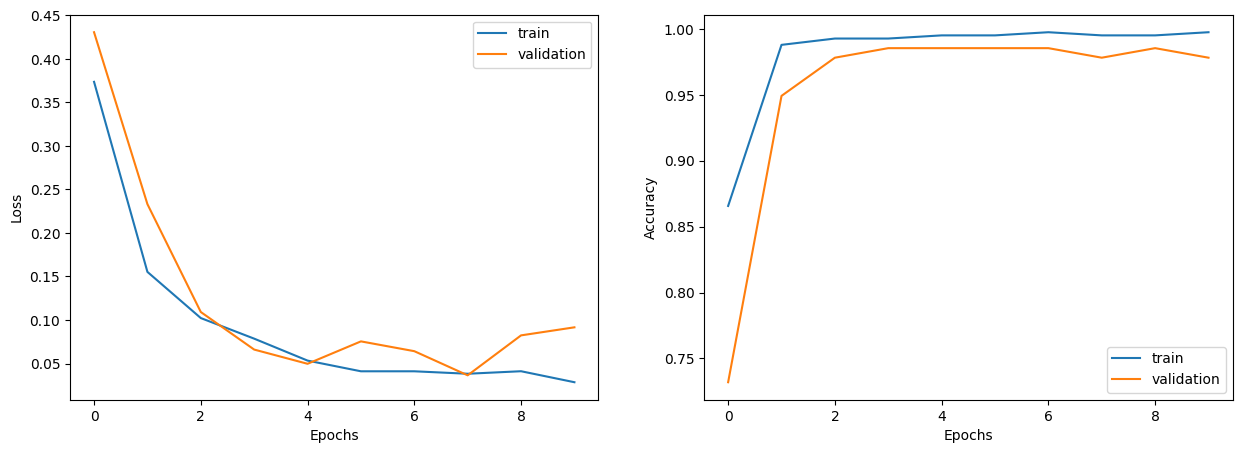

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['acc'], label='train')
plt.plot(model.history.history['val_acc'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

## Saving model

In [13]:
model.save('keras_model', save_format="h5")